# Formation du modèle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_final.csv')

In [3]:
df.head()

,Name,Path,Target,x0,y0,z0,x1,y1,z1,x2,...,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20
0,A_000,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.229569,0.444634,-0.000014,0.266084,0.391483,-0.017858,0.293316,...,-0.023318,0.187018,0.260286,-0.044687,0.196690,0.304484,-0.043205,0.198647,0.313999,-0.027439
1,A_001,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.326145,0.457524,0.000023,0.356874,0.438809,-0.031042,0.384046,...,-0.035017,0.299476,0.338017,-0.056236,0.306872,0.371106,-0.060166,0.312788,0.375171,-0.054218
2,A_002,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.389025,0.445136,0.000024,0.425415,0.420819,-0.022708,0.456886,...,-0.032746,0.368978,0.306833,-0.048165,0.374945,0.342649,-0.054728,0.376168,0.347345,-0.054231
3,A_003,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.074114,0.572558,-0.000011,0.139794,0.579121,-0.042297,0.202413,...,-0.008108,0.097871,0.409136,-0.041117,0.093771,0.457411,-0.041635,0.100784,0.474702,-0.017104
4,A_004,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.145682,0.324369,-0.000038,0.217293,0.309837,-0.016368,0.269147,...,0.003826,0.184741,0.124865,-0.022037,0.181261,0.173076,-0.031378,0.185656,0.193296,-0.011991


## Clean CSV

Nous commençons par supprimer les valeurs manquantes dans le csv.

In [4]:
df.isna().sum()

Name        0
Path        0
Target      0
x0        328
y0        328
         ... 
y19       328
z19       328
x20       328
y20       328
z20       328
Length: 66, dtype: int64

In [5]:
df.dropna(inplace=True)

## Train test split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [7]:
X = df.iloc[:,3:]
y = df.iloc[:, 2]

enc = LabelEncoder()
y = enc.fit_transform(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(448, 63)
(24, 63)
(448,)
(24,)


# RandomForestClassifier

Pour le modèle nous utilisons deux méthodes, un split simple avec `train_test_split` et `StratifiedKFold` de sklearn, qui nous permet de répartir équitablement chaque classe dans nos train et test.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [10]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
print(skf)

for train_index, test_index in skf.split(X, y):
    X_train_2, X_test_2 = X.iloc[train_index], X.iloc[test_index]
    y_train_2, y_test_2 = y[train_index], y[test_index]

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


In [11]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

model_2 = RandomForestClassifier()
model_2.fit(X_train_2, y_train_2)

RandomForestClassifier()

### Evaluation du modèle

In [12]:
predictions = model.predict(X_test)
predictions_2 = model.predict(X_test_2)

In [13]:
print('Accuracy Model 1 : ', accuracy_score(y_test, predictions))
print('Accuracy Model 2 : ', accuracy_score(y_test_2, predictions_2))

Accuracy Model 1 :  0.625
Accuracy Model 2 :  0.9745762711864406


Nous pouvons remarquer qu'une meilleurs répartition des classes dans nos données de train et test nous donne un modèle avec une précision bien supérieur qu'un simple split soit **97,46 %** contre **62 %**. Nous utiliserons donc ce modèle.

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<AxesSubplot:>

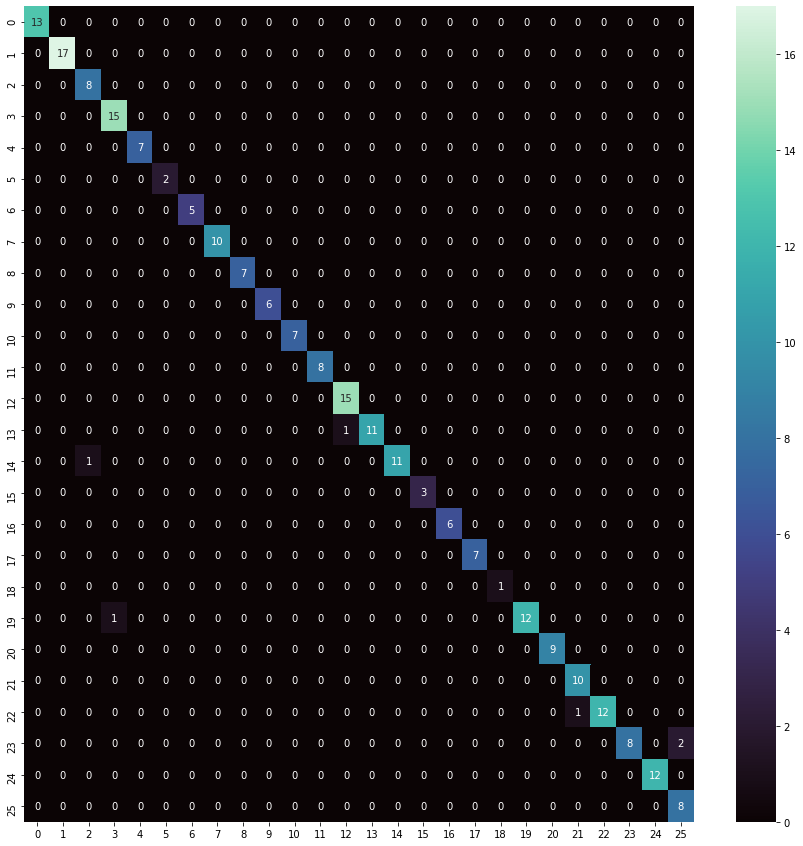

In [15]:
cm = confusion_matrix(y_test_2, predictions_2)
plt.figure(figsize=(15,15))
sns.heatmap(cm, cmap='mako', annot=True, fmt='d')

## Save Model

In [55]:
import pickle

pickle.dump(model_2, open('model_2.sav', 'wb'))

# Test Model

In [32]:
import mediapipe as mp
import cv2
from string import ascii_lowercase

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

dico = {k: v for k, v in enumerate(ascii_lowercase)}
print(dico)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [53]:
cap = cv2.VideoCapture(0)

#Initiate holistic model:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        #Recolor Feed
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        #Make detection
        results = holistic.process(img)
        input_model = []
        
        try:
            coords = results.right_hand_landmarks.landmark
        
            for coord in coords:
                input_model.append(coord.x)
                input_model.append(coord.y)
                input_model.append(coord.z)
        
        except: pass
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        #Right hand
        mp_drawing.draw_landmarks(img, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        
        try: 
            input_model = np.array(input_model).reshape(1, 63)
            pred = model_2.predict(input_model)
            img = cv2.putText(img, dico[pred[0]],(250,450), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),5)
        except: pass
        
        cv2.imshow('Test Mediapipe', img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()